In [40]:
from fastai.vision import *

### Get the tree different car names from auto-mpg dataset 

### Create directories and uploads urls files into the server 

In [3]:
path = Path('data/cars')

In [5]:
folders = ["ford_gran_torino", "amc_rebel", "playmouth_satellite"]

for folder in folders:
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)

In [9]:
path.ls()

[PosixPath('data/cars/playmouth_satellite'),
 PosixPath('data/cars/amc_rebel'),
 PosixPath('data/cars/ford_gran_torino')]

### Download images 

In [11]:
files = ["urls_ford_gran_torino.csv",
         "urls_amc_rebel.csv", 
         "urls_playmouth_satellite.csv"]

for file, folder in zip(files, folders):
    download_images(path/file, path/folder, max_pics=200)

#### remove images that can't be open 

In [12]:
classes = folders

for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

### View data

In [19]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path,
                                   train=".",
                                   valid_pct=0.2,
                                   ds_tfms=get_transforms(),
                                   size=224,
                                   num_workers=4).normalize(imagenet_stats)

In [16]:
data.classes

['amc_rebel', 'ford_gran_torino', 'playmouth_satellite']

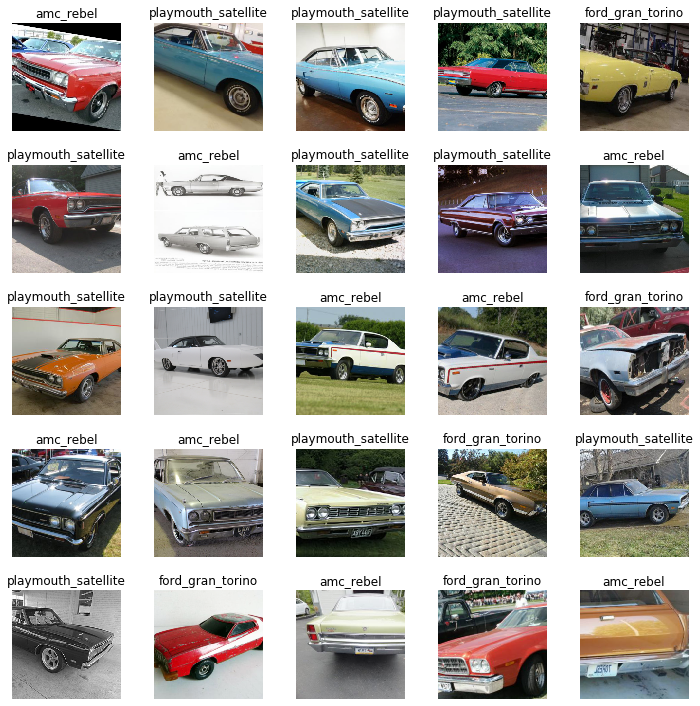

In [20]:
data.show_batch(row=3, figsize=(10,10))

In [24]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['amc_rebel', 'ford_gran_torino', 'playmouth_satellite'], 3, 452, 113)

### Train model 

In [26]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [30]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.343394,0.755903,0.327434,00:03
1,0.322211,0.790393,0.318584,00:03
2,0.312608,0.746915,0.265487,00:03
3,0.300219,0.729566,0.283186,00:03


In [32]:
learn.save('stage-1')

In [33]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


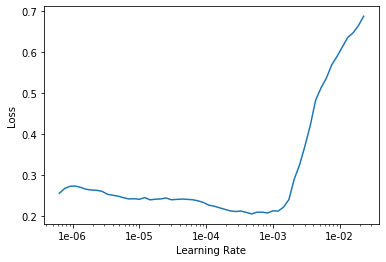

In [34]:
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(4, max_lr=slice(3e-6, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.182331,0.820503,0.274336,00:03
1,0.150638,0.784561,0.238938,00:03
2,0.135535,0.767519,0.247788,00:03
3,0.134233,0.749084,0.221239,00:03


In [39]:
learn.save("stage-2")

## Interpretation 

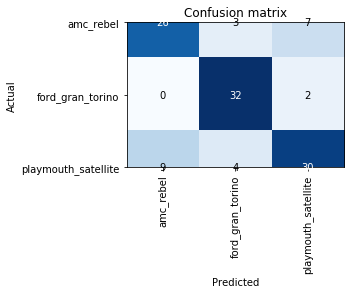

In [42]:
learn.load("stage-2")
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Cleaning Up

In [44]:
from fastai.widgets import *

In [58]:
db = (ImageList.from_folder(path)
                     .split_none()
                     .label_from_folder()
                     .transform(get_transforms(), size=224)
                     .databunch()
     )
db

ImageDataBunch;

Train: LabelList (565 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
playmouth_satellite,playmouth_satellite,playmouth_satellite,playmouth_satellite,playmouth_satellite
Path: data/cars;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/cars;

Test: None

In [48]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load("stage-2");

In [49]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [53]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

#### Delete duplicates

In [59]:
db = (ImageList.from_csv(path, csv_name="cleaned.csv")
                     .split_none()
                     .label_from_folder()
                     .transform(get_transforms(), size=224)
                     .databunch()
     )
db

ImageDataBunch;

Train: LabelList (558 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
playmouth_satellite,playmouth_satellite,playmouth_satellite,playmouth_satellite,playmouth_satellite
Path: data/cars;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/cars;

Test: None

In [61]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [62]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [64]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

## Train after clean up 

In [65]:
data = ImageDataBunch.from_csv(path,
                               folder=".",
                               valid_pct=0.2,
                               csv_labels="cleaned.csv",
                               ds_tfms=get_transforms(),
                               size=224,
                               num_workers=4).normalize(imagenet_stats)

In [66]:
data

ImageDataBunch;

Train: LabelList (438 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
playmouth_satellite,playmouth_satellite,playmouth_satellite,playmouth_satellite,playmouth_satellite
Path: data/cars;

Valid: LabelList (109 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
playmouth_satellite,playmouth_satellite,amc_rebel,amc_rebel,amc_rebel
Path: data/cars;

Test: None

In [70]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [72]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.661592,0.874861,0.293578,00:02
1,0.647892,0.818391,0.275229,00:03
2,0.573305,0.812901,0.256881,00:03
3,0.549208,0.803769,0.238532,00:03


In [73]:
learn.unfreeze()

In [74]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


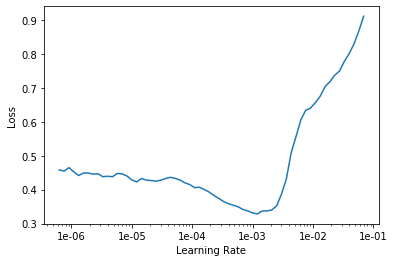

In [75]:
learn.recorder.plot()

In [79]:
np.random.seed(42)
learn.fit_one_cycle(2, max_lr=slice(3e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.098526,0.942174,0.201835,00:03
1,0.119969,0.998278,0.183486,00:03


In [80]:
learn.save("stage-3")

In [84]:
np.random.seed(42)
learn.fit_one_cycle(1, max_lr=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.017205,0.697656,0.155963,00:03


In [85]:
learn.save("stage-4")

In [86]:
learn.fit_one_cycle(1, max_lr=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.024988,0.628695,0.146789,00:03


In [87]:
learn.save("stage-5")

In [91]:
learn.fit_one_cycle(1, max_lr=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.051546,0.744203,0.174312,00:03


#### Pickle the best model 

In [92]:
learn.load("stage-5")
learn.export()

## Put the model into production 

In [93]:
path_model = Path("model")

In [96]:
defaults.device = torch.device("cpu")

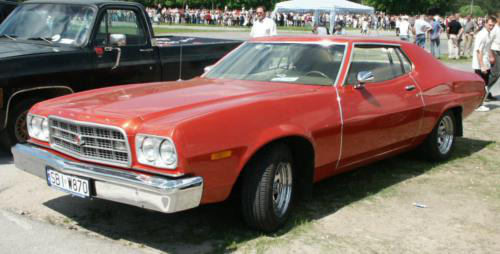

In [98]:
img = open_image(path/"ford_gran_torino"/"00000010.jpg")
img

In [99]:
learn = load_learner(path_model)

In [100]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

Category ford_gran_torino